# Seminar Software Composition Python Metrics tests

In [1]:
import pandas as pd
from tqdm.notebook import tqdm, trange
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ludo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
DATASET_FILE = 'class_comments_pharo.csv'

dataset = pd.read_csv(DATASET_FILE, header=None, names=['class', 'comment'])

dataset[:10]

,class,comment
0,AColorSelectorMorph,ColorComponentSelector showing an alpha gradie...
1,ASTCache,I am a simple cache for AST nodes correspondin...
2,ASTCacheReset,Announcement signaled to tell that the default...
3,ASTCacheResetTest,NaN
4,ASTEvaluationTest,I am testing AST evaluation
5,ASTPluginMeaningOfLife,A simple example for a AST transforming compil...
6,ASTTransformExamplePluginActive,This class changes the default compiler used t...
7,ASTTransformationPluginTest,NaN
8,ATraitedClass,Simple class to be traited in the tests
9,Abort,Notify to abort a task


## Dataset preparation

### Replace the NaN in the comments with empty string (IE empty comments)

In [3]:
df = dataset.copy()

df["comment"].fillna(" ", inplace=True)

print(f"Any null values left : {df.isnull().values.any()}")

Any null values left : False


### Comment length

In [4]:
nltk.download('stopwords')

comments = df["comment"]
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ludo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def preprocess_comment(comment, stopwords):
    # split the comment text into lowercase words
    comment = nltk.word_tokenize(comment)
    comment = (word.lower() for word in comment)

    # filter the stopwords and the punctuation
    try:
        comment = [word for word in comment if word.lower not in stopwords]
    except:
        print(e)
    
    return comment

comments = [preprocess_comment(comment, stopwords=stopwords) for comment in comments]

In [6]:
min_comment_len = 3
n_lower_length = 0

n_empty_comments = sum(map(lambda comment: 1 if len(comment) == 0 else 0, comments))
n_lower_length = sum(map(lambda comment: 1 if len(comment) < min_comment_len and len(comment) > 0 else 0, comments))

print(f"Total number of comments : {len(comments)}\n")
print(f"Number of empty comments : {n_empty_comments}")
print(f"Ratio of empty comments : {(n_empty_comments / len(comments))*100:.1f} %\n")

print(f"Number of comments with too few words (but not empty) : {n_lower_length}")
print(f"Ratio of comments too short : {(n_lower_length / len(comments))*100:.1f} %")

Total number of comments : 7863

Number of empty comments : 1541
Ratio of empty comments : 19.6 %

Number of comments with too few words (but not empty) : 41
Ratio of comments too short : 0.5 %


#### Plots

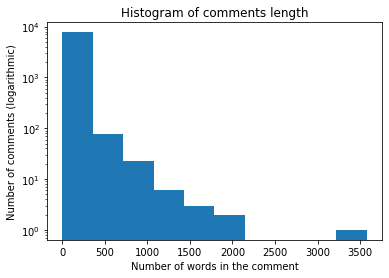

In [24]:
import matplotlib.pyplot as plt
from collections import Counter

comments_len = list(map(lambda c: len(c), comments))

plt.hist(comments_len)
plt.yscale(value='log')
plt.title('Histogram of comments length')
plt.ylabel('Number of comments (logarithmic)')
plt.xlabel('Number of words in the comment')
plt.show()